# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando Perceptron Logístico.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

# Pacote do trabalho (funções utilitárias e modelos)
from trabalho_ic_aplicada.models import aux, reg_mlp


np.random.seed(42)


2025-08-19 20:30:10.673 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


## [01] Carregamento do dataset e pré-processamento básico

In [2]:
real_estate_valuation = fetch_ucirepo(id=477)

# Nomes das variáveis (apenas informativo; a primeira é a data de transação)
features = real_estate_valuation.variables.iloc[1:, 0].values

# Matriz de atributos e vetor-alvo
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()

# Remove a 1ª coluna (data de transação), considerada não relevante
X = X[:, 1:]

# Índices dos folds para CV (k-fold estratificado não é essencial para regressão)
k_fold = aux.validacao_cruzada_kfold(X, y, k=10)

## [02] Hiperparâmetros e estruturas para coleta das métricas

- n_epocas: épocas de treinamento da MLP rala (camada de saída sigmoide)
- taxa_aprendizagem: passo constante (eta_i == eta_f)


In [3]:
n_epocas = 100
taxa_aprendizagem = 0.005

# Listas para métricas por fold (teste)
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Correlações (treino/teste) por fold
correlacoes_treino = []
correlacoes_teste = []

# Para análises finais (resíduos/curvas de perda)
train_losses = []       # histórico de perda por fold
y_trains = []           # y verdadeiro (treino, todos folds)
y_train_preds = []      # y predito (treino, todos folds)
y_tests = []            # y verdadeiro (teste, todos folds)
y_test_preds = []       # y predito (teste, todos folds)


## [03] Loop de validação cruzada: treino, previsão e métricas por fold

Pré-processamento:
 - Features: QuantileTransformer (uniforme) para robustez a outliers
 - Alvo: MinMaxScaler para mapear y ∈ [0,1] (compatível com saída sigmoide)

Modelo:
 - MLP rala com camada de saída sigmoide (sem oculta: layer_sizes=[p,1])

Avaliação:
 - Métricas via aux.calcular_metricas e correlações de Pearson

In [4]:

for k in range(len(k_fold)):
    # Split por índices do fold k
    tr_idx, te_idx = k_fold[k]
    X_train_k = X[tr_idx, :]
    y_train_k = y[tr_idx].reshape(-1, 1)  # (n,1)
    X_test_k  = X[te_idx, :]
    y_test_k  = y[te_idx].reshape(-1, 1)

    # ---- Normalização das features (ajustar no treino, aplicar no teste)
    scaler_X = QuantileTransformer(
        n_quantiles=min(X_train_k.shape[0], 1000),  # limite prático
        output_distribution='uniform',
        random_state=42
    )
    X_train_k_norm = scaler_X.fit_transform(X_train_k)
    X_test_k_norm  = scaler_X.transform(X_test_k)

    # ---- Normalização do alvo para [0,1] (apenas com dados de treino)
    scaler_y = MinMaxScaler()
    y_train_k_norm = scaler_y.fit_transform(y_train_k)

    # ---- Treino da MLP rala (perceptron logístico para regressão)
    # layer_sizes: [n_features, 1] => sem camada oculta; ativações sigmoide
    weights, loss_history = reg_mlp.train_mlp_regression(
        X_train_k_norm,
        y_train_k_norm,
        layer_sizes=[X_train_k.shape[1], 1],
        epochs=n_epocas,
        eta_i=taxa_aprendizagem,
        eta_f=taxa_aprendizagem,
        hidden_activation='sigmoid',   # mantido para compatibilidade
        output_activation='sigmoid',
        verbose=False
    )
    train_losses.append(loss_history)

    # ---- Predição (treino) e desscala para o domínio original de y
    y_pred_train_norm = reg_mlp.predict_mlp_regression(
        X_train_k_norm, weights,
        hidden_activation='sigmoid',
        output_activation='sigmoid'
    )
    y_pred_train = scaler_y.inverse_transform(
        y_pred_train_norm.reshape(-1, 1)
    ).flatten()

    # Correlação no treino
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train)[0, 1]
    correlacoes_treino.append(corr_treino)

    # ---- Predição (teste) e desscala
    y_pred_test_norm = reg_mlp.predict_mlp_regression(
        X_test_k_norm, weights,
        hidden_activation='sigmoid',
        output_activation='sigmoid'
    )
    y_pred_test = scaler_y.inverse_transform(
        y_pred_test_norm.reshape(-1, 1)
    ).flatten()

    # Correlação no teste
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test)[0, 1]
    correlacoes_teste.append(corr_teste)

    # ---- Acumula para análises globais
    y_trains.extend(y_train_k.flatten())
    y_train_preds.extend(y_pred_train.flatten())
    y_tests.extend(y_test_k.flatten())
    y_test_preds.extend(y_pred_test.flatten())

    # ---- Métricas (teste) por fold
    # Nota: aux.calcular_metricas(y_true, y_pred, aux) retorna
    # (EQM, REQM, R2, hit@20%, hit@10%, residuos)
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(
        y_test_k.flatten(), y_pred_test, aux
    )
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

## [04] Consolidação, impressão de métricas e análise de resíduos

- Tabelas resumidas (médias/DP) via utilitários em aux.*
- Histograma de resíduos (treino) e dispersões (treino/teste)
- Curvas de perda por fold

Erro Quadrático Médio (EQM): 91.7239 ± 34.7189
Raiz do Erro Quadrático Médio (REQM): 9.4217 ± 1.7191
Hit rate 20%: 0.6272 ± 0.0728
Hit rate 10%: 0.3569 ± 0.0873

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7373 ± 0.0449
Correlação Média (Teste): 0.7212 ± 0.0678
Coeficiente de Determinação (R²): 0.5004 ± 0.0927

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9034, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9096, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


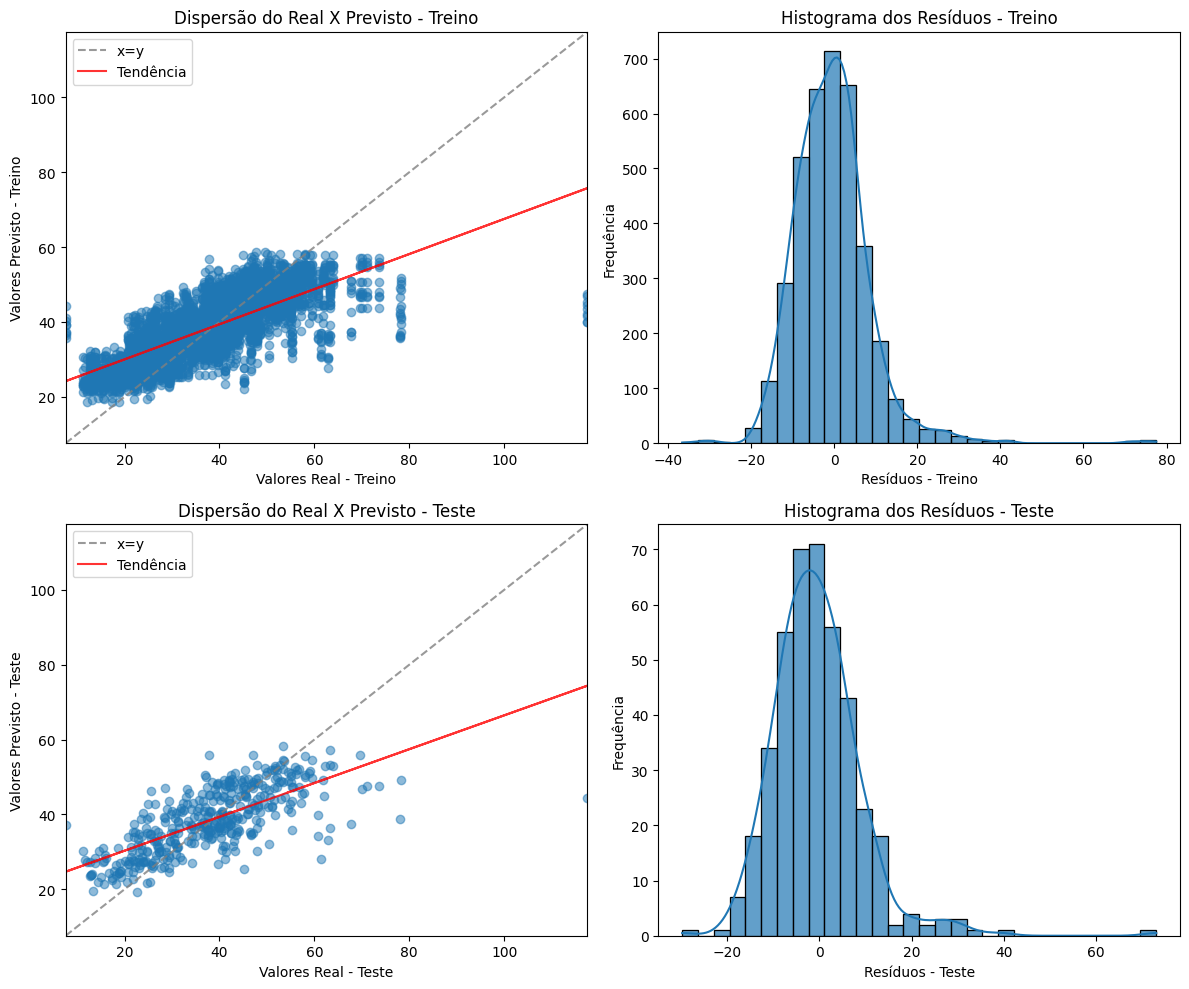

Avg. house price: 38.4347 ± 8.6356
RSME/Avg. house price: 0.1900 ± 0.1809


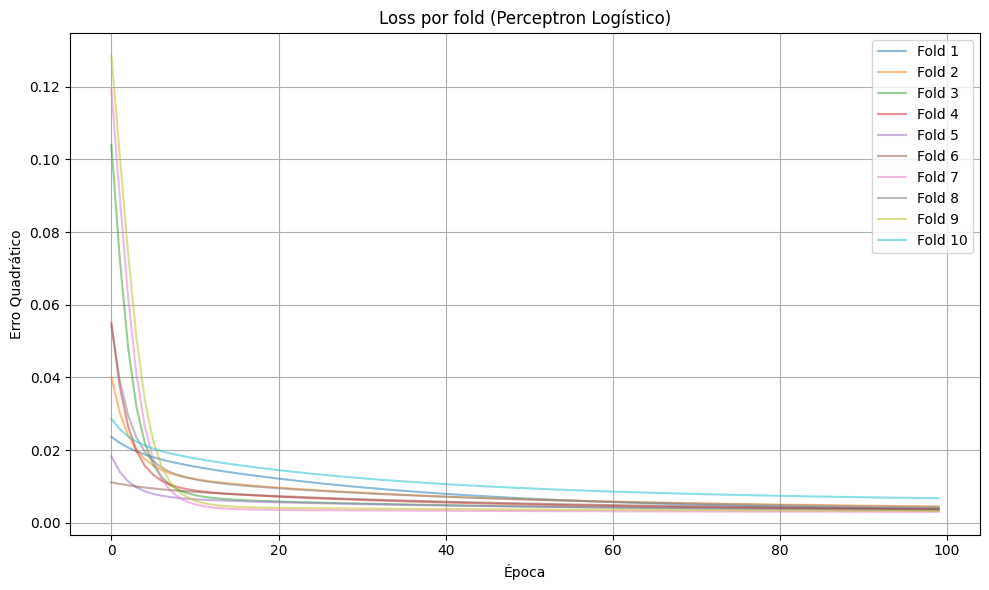

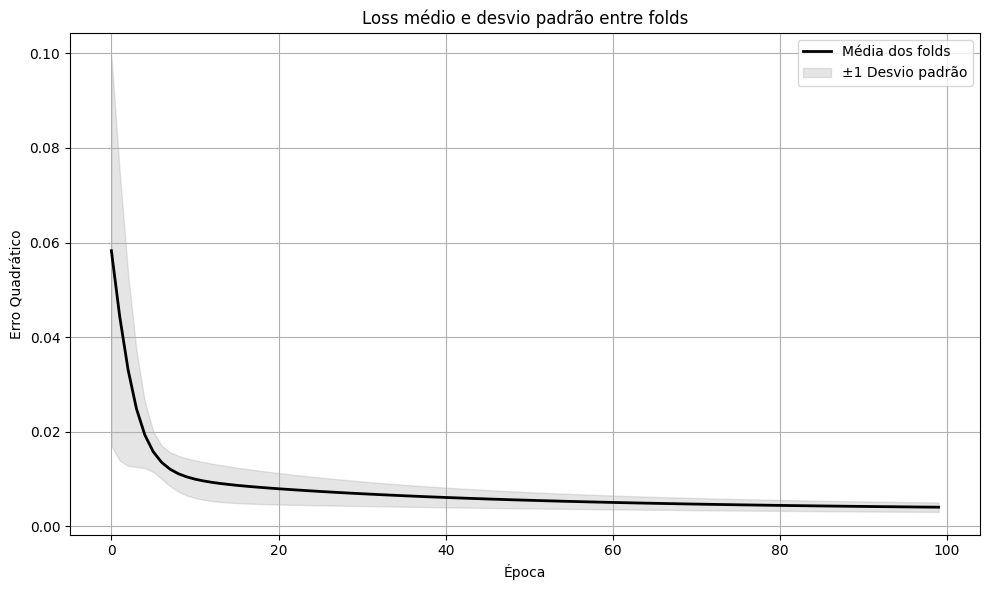

In [5]:

# Arrays para funções que esperam numpy
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# ---- Resumos de métricas por fold (teste)
aux.imprimir_metricas(
    eqms_iqr, reqms_iqr, r_quadrados_iqr,
    hit_rates_20_iqr, hit_rates_10_iqr
)

# ---- Correlações (treino/teste) e R^2 (teste)
aux.imprimir_correlacoes(
    correlacoes_treino, correlacoes_teste, r_quadrados_iqr
)

# ---- Análise de resíduos e gráficos:
#     - Histograma dos resíduos (treino)
#     - Dispersões y_true vs y_pred (treino e teste)
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão Perceptron Logístico (saída sigmoide)'
)
aux.calcular_metricas_normalizadas(y_test_preds, y_tests)

# ---- Curvas de perda por fold
aux.plot_folds_loss(
    train_losses,
    titulo="Loss por fold (Perceptron Logístico)",
    ylabel="Erro Quadrático",
    xlabel="Época"
)

none
zscore
minmax
iqr
=== MELHOR COMBINAÇÃO (CV no TREINO) ===
{'normalizacao': 'iqr', 'epochs': 300, 'lr': 0.01, 'r2_val_mean': 0.6014945673172516, 'rmse_val_mean': 8.559450961697483, 'hit10_val_mean': 0.41224880382775114, 'hit20_val_mean': 0.7081339712918661}

=== DESEMPENHO NO TESTE (HOLD-OUT) ===
R² = 0.6623 | RMSE = 7.3600 | EQM = 54.1699 | Hit@10 = 0.4964 | Hit@20 = 0.7664

=== TOP-5 combinações na CV (médias de validação) ===
    iqr | ep=300 | lr=0.01 | R²=0.6015 | RMSE=8.5595 | Hit@10=0.4122 | Hit@20=0.7081
 zscore | ep=300 | lr=0.01 | R²=0.5878 | RMSE=8.6270 | Hit@10=0.4552 | Hit@20=0.7437
 zscore | ep=300 | lr=0.005 | R²=0.5871 | RMSE=8.6402 | Hit@10=0.4514 | Hit@20=0.7476
 zscore | ep=200 | lr=0.01 | R²=0.5802 | RMSE=8.6966 | Hit@10=0.4440 | Hit@20=0.7510
 zscore | ep=150 | lr=0.005 | R²=0.5767 | RMSE=8.7489 | Hit@10=0.4333 | Hit@20=0.7220
--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7930 ± 0.0000
Correlação Média (Teste): 0.8151 ± 0.

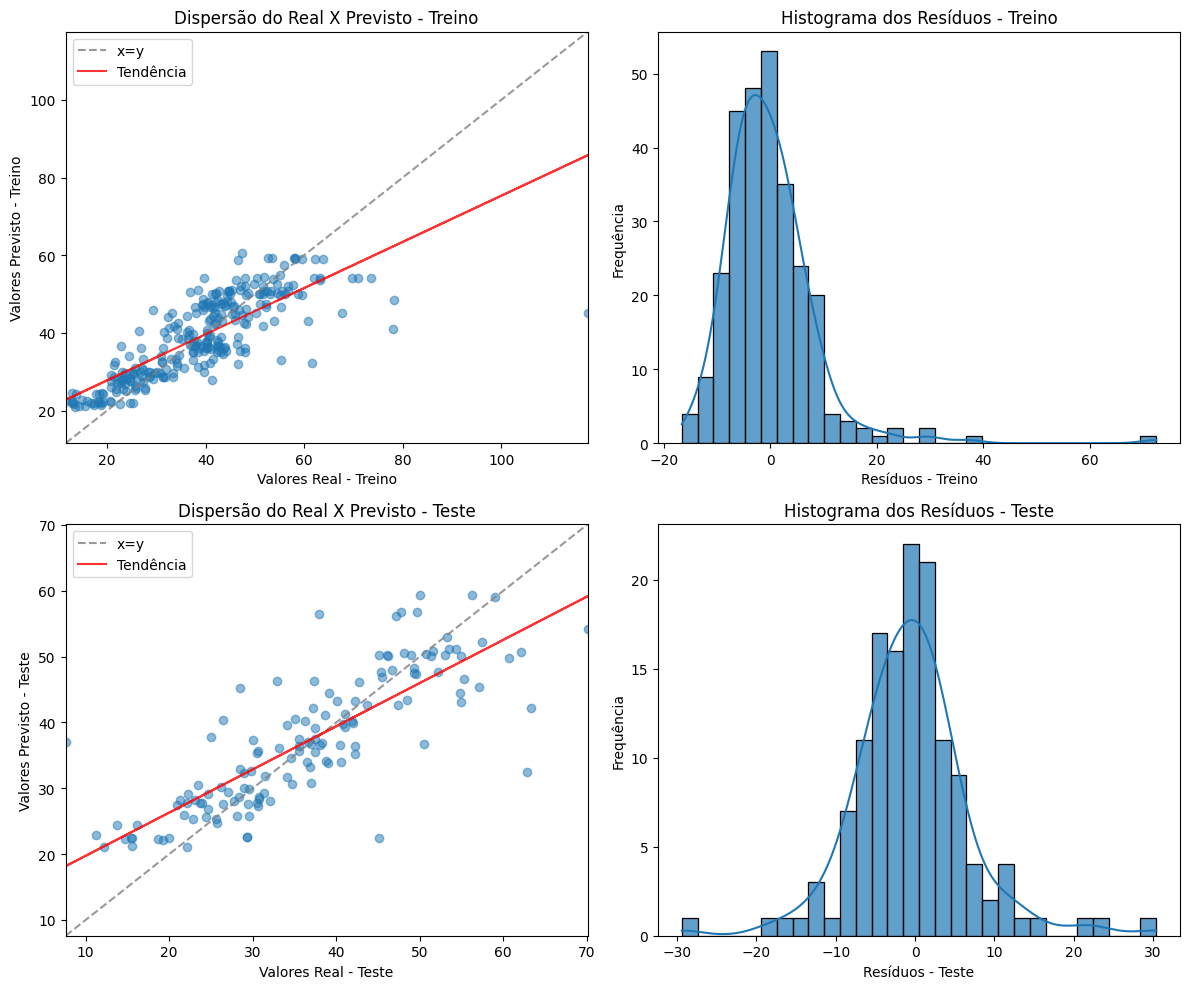

Avg. house price: 37.2545 ± 10.1938
RSME/Avg. house price: 0.1482 ± 0.1594


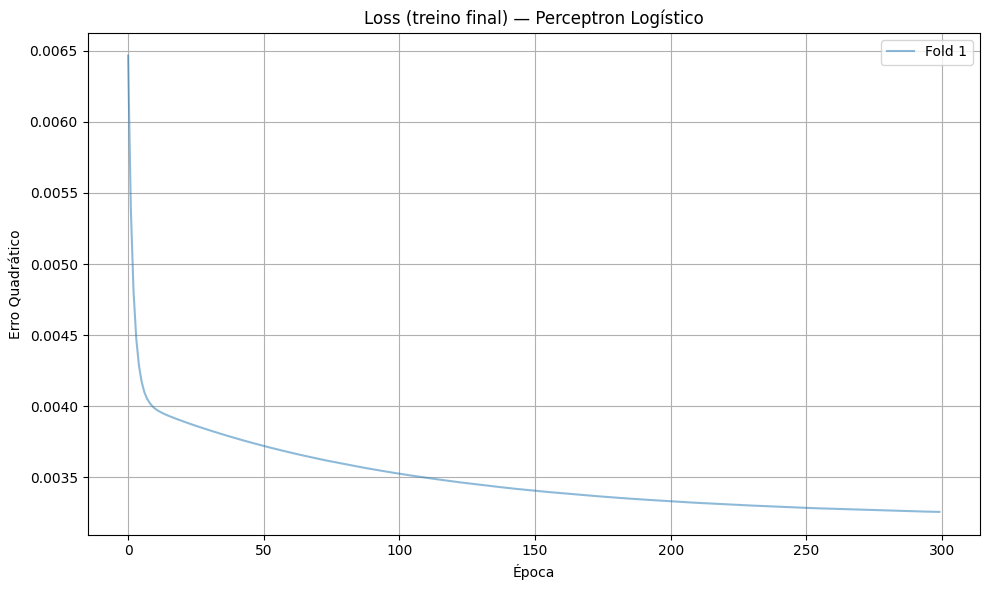

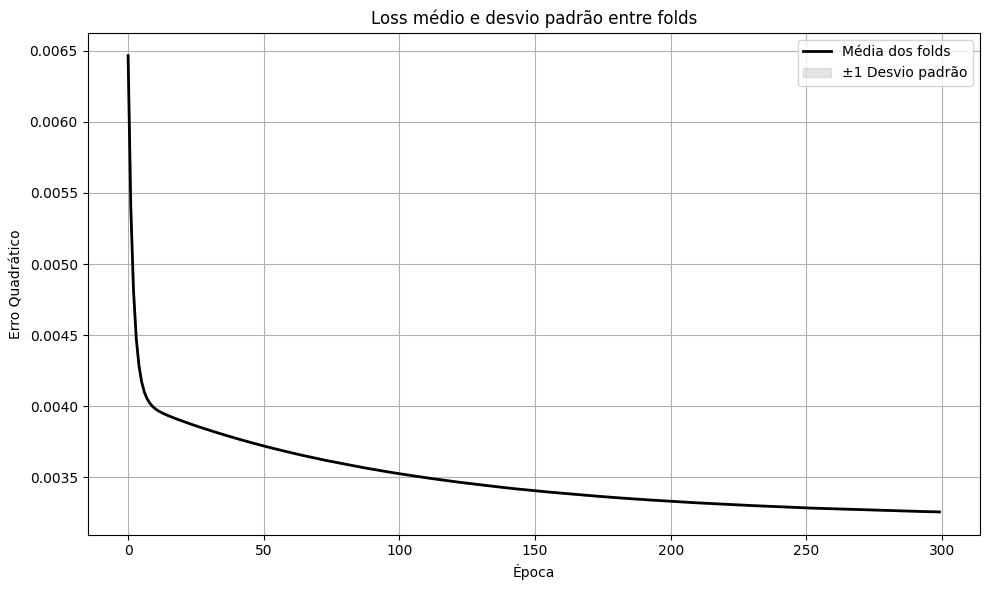

In [7]:
## [02] Seleção de normalização + HPs via CV no TREINO (k=5) e avaliação no TESTE (hold-out)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np

# -------------------------------
# Hold-out: treino/teste
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# K-fold APENAS no treino
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=5)

# Espaço de busca
epochs_list = [100, 150, 200, 300]  # inclui seu valor (100)
lr_list = [1e-3, 5e-3, 1e-2]  # inclui seu valor (0.005)
norm_options = ["none", "zscore", "minmax", "iqr"]


def make_scaler(name: str, n_samples: int):
    if name == "none":
        class _NoOp:
            def fit(self, X): return self

            def transform(self, X): return X

            def fit_transform(self, X): return X

        return _NoOp()
    if name == "zscore":
        return StandardScaler()
    if name == "minmax":
        return MinMaxScaler()
    if name == "iqr":
        return QuantileTransformer(
            n_quantiles=min(n_samples, 1000),
            output_distribution="uniform",
            random_state=42
        )
    raise ValueError(f"Normalização desconhecida: {name}")


cv_rows = []
for norm_name in norm_options:
    print(f"{norm_name}")
    for epochs in epochs_list:
        for lr in lr_list:
            r2_list, rmse_list, hit10_list, hit20_list = [], [], [], []

            for k in range(len(k_fold_train)):
                tr_idx, va_idx = k_fold_train[k]

                X_tr = X_train[tr_idx, :]
                y_tr = y_train[tr_idx].reshape(-1, 1)
                X_va = X_train[va_idx, :]
                y_va = y_train[va_idx].reshape(-1, 1)

                # --- scaler X por fold ---
                scaler_X = make_scaler(norm_name, X_tr.shape[0])
                X_tr_s = scaler_X.fit_transform(X_tr)
                X_va_s = scaler_X.transform(X_va)

                # --- scaler y por fold (sempre MinMax -> saída sigmoide) ---
                scaler_y = MinMaxScaler()
                y_tr_s = scaler_y.fit_transform(y_tr)

                # --- treino MLP rala ---
                weights, _ = reg_mlp.train_mlp_regression(
                    X_tr_s, y_tr_s,
                    layer_sizes=[X_tr.shape[1], 1],
                    epochs=epochs,
                    eta_i=lr, eta_f=lr,
                    hidden_activation='sigmoid',
                    output_activation='sigmoid',
                    verbose=False
                )

                # --- previsão em validação (desscala para o domínio original) ---
                y_va_pred_s = reg_mlp.predict_mlp_regression(
                    X_va_s, weights,
                    hidden_activation='sigmoid',
                    output_activation='sigmoid'
                ).reshape(-1, 1)
                y_va_pred = scaler_y.inverse_transform(y_va_pred_s).flatten()

                # métricas de validação
                eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(
                    y_va.flatten(), y_va_pred, aux
                )
                r2_list.append(r2)
                rmse_list.append(reqm)
                hit10_list.append(hit10)
                hit20_list.append(hit20)

            cv_rows.append({
                "normalizacao": norm_name,
                "epochs": epochs,
                "lr": lr,
                "r2_val_mean": float(np.mean(r2_list)),
                "rmse_val_mean": float(np.mean(rmse_list)),
                "hit10_val_mean": float(np.mean(hit10_list)),
                "hit20_val_mean": float(np.mean(hit20_list)),
            })

# ordena: maior R², depois menor RMSE, depois maior Hit@10
cv_rows_sorted = sorted(
    cv_rows,
    key=lambda d: (-d["r2_val_mean"], d["rmse_val_mean"], -d["hit10_val_mean"])
)
best = cv_rows_sorted[0]
print("=== MELHOR COMBINAÇÃO (CV no TREINO) ===")
print(best)

## [03] Reajuste no TREINO COMPLETO com a melhor combinação e avaliação no TESTE
# Scalers definitivos
scaler_X_best = make_scaler(best["normalizacao"], X_train.shape[0])
X_train_s = scaler_X_best.fit_transform(X_train)
X_test_s = scaler_X_best.transform(X_test)

scaler_y_best = MinMaxScaler()
y_train_s = scaler_y_best.fit_transform(y_train.reshape(-1, 1))

# Treino final
weights_best, loss_history_best = reg_mlp.train_mlp_regression(
    X_train_s, y_train_s,
    layer_sizes=[X_train.shape[1], 1],
    epochs=best["epochs"],
    eta_i=best["lr"], eta_f=best["lr"],
    hidden_activation='sigmoid',
    output_activation='sigmoid',
    verbose=False
)

# Predições no treino (para resíduos) e no teste (hold-out)
y_train_pred_s = reg_mlp.predict_mlp_regression(
    X_train_s, weights_best,
    hidden_activation='sigmoid',
    output_activation='sigmoid'
).reshape(-1, 1)
y_train_pred = scaler_y_best.inverse_transform(y_train_pred_s).flatten()

y_test_pred_s = reg_mlp.predict_mlp_regression(
    X_test_s, weights_best,
    hidden_activation='sigmoid',
    output_activation='sigmoid'
).reshape(-1, 1)
y_test_pred = scaler_y_best.inverse_transform(y_test_pred_s).flatten()

# Métricas no hold-out
eqm_t, rmse_t, r2_t, hit20_t, hit10_t, _ = aux.calcular_metricas(y_test, y_test_pred, aux)
print("\n=== DESEMPENHO NO TESTE (HOLD-OUT) ===")
print(f"R² = {r2_t:.4f} | RMSE = {rmse_t:.4f} | EQM = {eqm_t:.4f} | "
      f"Hit@10 = {hit10_t:.4f} | Hit@20 = {hit20_t:.4f}")

# Top-5 combinações (CV)
print("\n=== TOP-5 combinações na CV (médias de validação) ===")
for row in cv_rows_sorted[:5]:
    print(f"{row['normalizacao']:>7} | ep={row['epochs']:>3} | lr={row['lr']:<.4g} | "
          f"R²={row['r2_val_mean']:.4f} | RMSE={row['rmse_val_mean']:.4f} | "
          f"Hit@10={row['hit10_val_mean']:.4f} | Hit@20={row['hit20_val_mean']:.4f}")

## [04] Análise de resíduos (APENAS hold-out; sem k-fold)
# Correlações (opcional)
corr_tr = np.corrcoef(y_train, y_train_pred)[0, 1]
corr_te = np.corrcoef(y_test, y_test_pred)[0, 1]
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_t])

# Resíduos e gráficos apenas com hold-out
aux.analisar_residuos(
    y_train, y_train_pred,
    y_test, y_test_pred,
    aux,
    titulo='Perceptron Logístico (saída sigmoide) — hold-out'
)

# Métricas normalizadas (se aplicável no seu pipeline)
aux.calcular_metricas_normalizadas(y_test_pred, y_test)

# Curva de perda do treino final (se quiser visualizar)
aux.plot_folds_loss(
    [loss_history_best],
    titulo="Loss (treino final) — Perceptron Logístico",
    ylabel="Erro Quadrático",
    xlabel="Época"
)
